In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pb
import matplotlib.pyplot as plt
import seaborn as sns

LOCAL = True
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    PATH = "/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/"
    MPRA = os.path.join(PATH, "delta_rank.csv")
    #MPRA= os.path.join(PATH, "deltaMPRA.gaba.minus.glut.tsv")
    FASTA = os.path.join(PATH, "library_2", "Design", "biomarin-lib2-hg38-final.fasta")
    META_DATA= os.path.join(PATH, "lib2.meta_data.tsv")
    TILE_BED = os.path.join(PATH, "lib2.processed.bed")
    ENH_BED = os.path.join(PATH,'lib2.processed.merged.bed')
    GREAT_GENE_TSV = os.path.join(PATH, "GREAT", f"region2gene_lib2hg38.tsv")
                         
import config_readwrite as crw
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [12]:
meta = pd.read_csv(META_DATA, sep='\t')
merge = pd.read_csv(ENH_BED, sep='\t')

merge.head()

,#chr,start.tile,end.tile,coor,#chr.enh,start.enh,end.enh,enh.id,enh.name,tile.order
0,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,0
1,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,1
2,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,2
3,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,3
4,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,4


In [3]:
len(set(merge["enh.id"]))

1827

# load MPRA data

In [6]:
mpra = pd.read_csv(MPRA)
#mpra = mpra.rename(columns ={"delta.gaba-glut":"delta"})
print(mpra.shape)
mpra.head()

(35371, 5)


,name,gaba_log2_mean,glut_log2_mean,delta,delta_rank
0,chr1:10339772-10340042,-1.602773,0.466691,-2.069465,1.0
1,chr6:154127563-154127833,-0.460660,1.393760,-1.854420,2.0
2,chr4:93216597-93216867,-1.373226,0.426283,-1.799509,3.0
3,chr9:127735295-127735565,-0.784093,1.010851,-1.794944,4.0
4,chr1:31376876-31377146,-0.500106,1.291683,-1.791789,5.0


[Text(0.5, 1.0, 'delta MPRA'),
 Text(0.5, 0, 'delta\nmean log2(gaba) - mean log2(glut)')]

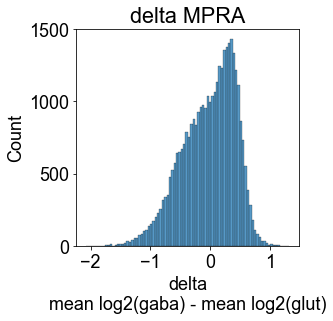

In [7]:
fig, ax = plt.subplots(figsize=(4,4))
sns.histplot(mpra["delta"])
ax.set(title="delta MPRA",
      xlabel="delta\nmean log2(gaba) - mean log2(glut)")

In [8]:
mpra["delta"].describe()

count    35371.000000
mean        -0.023292
std          0.442305
min         -2.069465
25%         -0.325397
50%          0.043795
75%          0.324542
max          1.319865
Name: delta, dtype: float64

# evaluate GREAT

In [9]:
# get nearby coordinates using GREAT nearest 2 gene function

## load great annotations

In [21]:
GREAT_GENE = os.path.join(os.path.split(MPRA)[0], "GREAT", f"region2gene_lib2hg38.txt")

locus_dict = {}
with open(GREAT_GENE, "r") as reader:
    for line in reader:
        if "#" not in line and line !="\n":
            
            locus, genes = line.strip("\n").split("\t")  # split on tab to get gene name

            info = [locus]
            
            for n, i in enumerate(genes.split(",")):
                if i != "NONE":
                    gene, dist = i.strip(" ").split(" ")
                    dist = dist.strip("()")
                else:
                    gene, dist = "na", "na"
                
                locus_dict[f'{locus}-{n}'] = [locus, gene, dist]


vstack = np.vstack(locus_dict.values())

great = pd.DataFrame(vstack)
great.columns = ["coor", "gene", 'dist']
great.head()

/Users/sarahfong/miniconda3/envs/base_venv/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


,coor,gene,dist
0,chr1:101316025-101316295,S1PR1,+79272
1,chr1:101316025-101316295,OLFM3,+530813
2,chr1:101316045-101316315,S1PR1,+79292
3,chr1:101316045-101316315,OLFM3,+530793
4,chr1:101316065-101316335,S1PR1,+79312


# add GREAT annotations to fasta meta data

In [22]:
enh = pd.merge(great, meta)

# rename columns for merging with MPRA data
enh = enh.rename(columns ={"start":"start.tile",
                           "end":"end.tile"})

enh.head()

,coor,gene,dist,name,sequence,bkgd,h,ctrl,cl,top_bottom,strand,#chr,start.tile,end.tile
0,chr1:101316025-101316295,S1PR1,+79272,chr1:101316025-101316295,AGGACCGGATCAACTAGAGTCACCCCTGCTGTTCCCCGTAGGATGA...,False,NaN,NaN,NaN,NaN,+,chr1,101316025.0,101316295
1,chr1:101316025-101316295,OLFM3,+530813,chr1:101316025-101316295,AGGACCGGATCAACTAGAGTCACCCCTGCTGTTCCCCGTAGGATGA...,False,NaN,NaN,NaN,NaN,+,chr1,101316025.0,101316295
2,chr1:101316045-101316315,S1PR1,+79292,chr1:101316045-101316315,AGGACCGGATCAACTCCGTAGGATGACGCTGGTGTAAAAAGGTTAC...,False,NaN,NaN,NaN,NaN,+,chr1,101316045.0,101316315
3,chr1:101316045-101316315,OLFM3,+530793,chr1:101316045-101316315,AGGACCGGATCAACTCCGTAGGATGACGCTGGTGTAAAAAGGTTAC...,False,NaN,NaN,NaN,NaN,+,chr1,101316045.0,101316315
4,chr1:101316065-101316335,S1PR1,+79312,chr1:101316065-101316335,AGGACCGGATCAACTAAAAAGGTTACCGTTGCTTCAGTGGCCCTTG...,False,NaN,NaN,NaN,NaN,+,chr1,101316065.0,101316335


# add MPRA

In [23]:
enh = pd.merge(enh, mpra)

# STOPPED HERE. FIGURE OUT MERGE BELOW. ADD MPRA ACTIVITY

In [24]:
# add enhancer coordinate information
enh[["start.tile", "end.tile"]] = enh[["start.tile", "end.tile"]].astype(int)

enh = pd.merge(enh, merge, 
               left_on = ["#chr", "start.tile", "end.tile", "coor"], 
               right_on=["#chr","start.tile", "end.tile", "coor"])
enh = enh.sort_values(by = ["#chr", "start.tile", "end.tile"])

enh.head()

,coor,gene,dist,name,sequence,bkgd,h,ctrl,cl,top_bottom,...,gaba_log2_mean,glut_log2_mean,delta,delta_rank,#chr.enh,start.enh,end.enh,enh.id,enh.name,tile.order
1678,chr1:1692002-1692272,CDK11B,-33125,chr1:1692002-1692272,AGGACCGGATCAACTCTCGTTTGGCCTGAAAATGTGATTTGCAGGC...,False,NaN,NaN,NaN,NaN,...,0.525588,0.205703,0.319886,26367.0,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,0
1679,chr1:1692002-1692272,SLC35E2B,+507,chr1:1692002-1692272,AGGACCGGATCAACTCTCGTTTGGCCTGAAAATGTGATTTGCAGGC...,False,NaN,NaN,NaN,NaN,...,0.525588,0.205703,0.319886,26367.0,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,0
1680,chr1:1692022-1692292,CDK11B,-33145,chr1:1692022-1692292,AGGACCGGATCAACTGATTTGCAGGCTTCCTGAGCAAAGTAGATTT...,False,NaN,NaN,NaN,NaN,...,0.602023,0.072854,0.529169,32783.0,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,1
1681,chr1:1692022-1692292,SLC35E2B,+487,chr1:1692022-1692292,AGGACCGGATCAACTGATTTGCAGGCTTCCTGAGCAAAGTAGATTT...,False,NaN,NaN,NaN,NaN,...,0.602023,0.072854,0.529169,32783.0,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,1
1682,chr1:1692042-1692312,CDK11B,-33165,chr1:1692042-1692312,AGGACCGGATCAACTAAAGTAGATTTCACTCCATTAAAGAAAAAAA...,False,NaN,NaN,NaN,NaN,...,0.532336,0.115079,0.417256,29772.0,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,2


In [32]:
def plot_lineplot(df, out, enh_id):
    
    fig, ax = plt.subplots()
    
    df["tile.order"]=df["tile.order"].astype(int)
    gene, min_dist =df.iloc[0]["gene"], df["dist"].min()
    df = df.sort_values(by="tile.order")
    
    # lineplots
    sns.lineplot(x="tile.order", y="glut_log2_mean", data = df, color = "blue", label="glut")
    sns.lineplot(x="tile.order", y="gaba_log2_mean", data = df, color = "orange", label="gaba")

    # zero line
    ax.axhline(0, c="grey", ls="--")
    
    # ax title, labels
    ax.set(title=f"{gene}, {min_dist}bp to TSS\n{enh_id}, {i}", 
          ylabel = "log2(RNA/DNA)", 
          ylim = (-1.5,1.5))
    
    # change settings for some 
    if i =='chr3:11000975-11001605':
        ax.set( ylim = (-2,1.2))
    plt.savefig(out, bbox_inches="tight")

# heatmap

In [37]:
def plot_heatmap(test, out, enh_name):
    t = test.set_index("tile.order")[["gaba_log2_mean", "glut_log2_mean", "enh.id", "gene", "dist"]]

    gene, min_dist, enh_id =t.iloc[0]["gene"], t["dist"].min(), t.iloc[0]["enh.id"]
    
    # reverse distance for negative values
    if int(min_dist)<1:
        min_dist = t["dist"].max()
        
    # this region is really big
    if enh_id =="chr6:33417727-33418836":
        fig, ax= plt.subplots(figsize = (12,4))
    else:
        fig, ax= plt.subplots(figsize = (8,4))
        
    sns.heatmap(t[["gaba_log2_mean", "glut_log2_mean"]].T,
                cmap="bwr", center=0, square=True, 
                 cbar_kws={'label': 'log2(RNA/DNA)'},
                #cbar_kws={"shrink": 0.5},
               ax=ax)
    ax.set(title=f"{gene}\n{min_dist} bp to TSS\n{enh_name}, {enh_id}")
    
    plt.savefig(out, bbox_inches="tight")

In [ ]:
great.loc[great["gene"]=="SLC^"]

In [39]:
test = enh.loc[enh.gene.isin(["SYNGAP1", "SLC6A1"])]

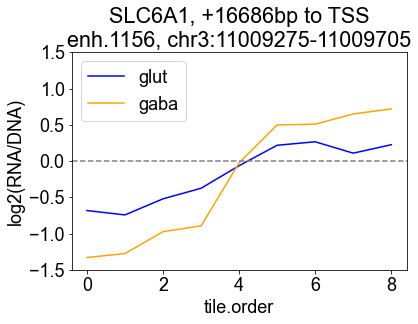

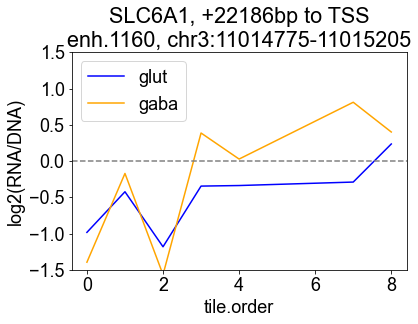

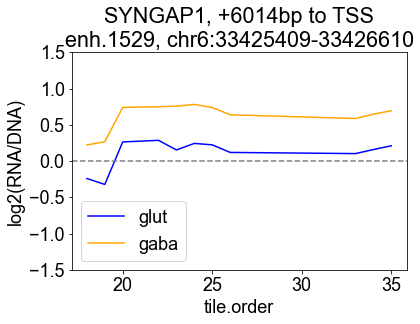

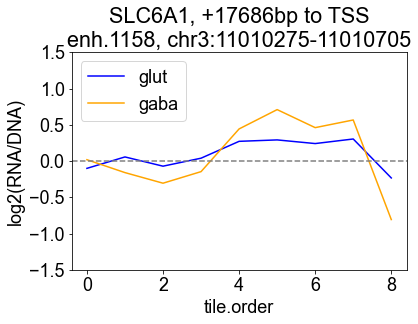

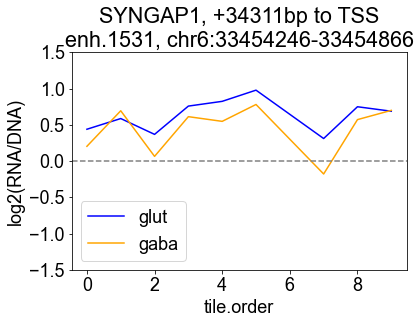

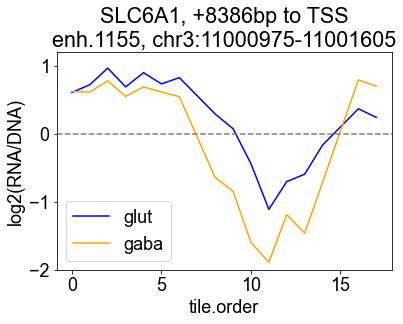

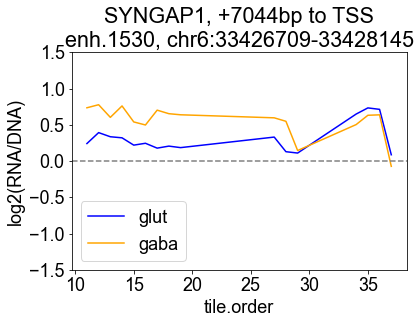

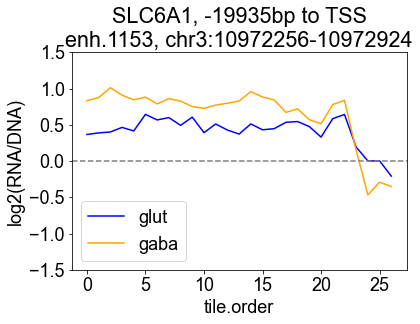

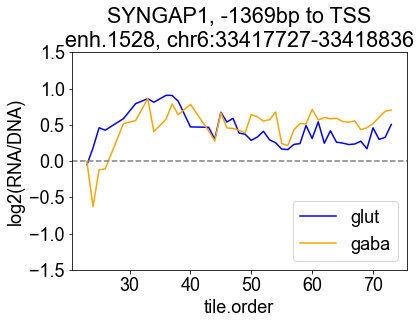

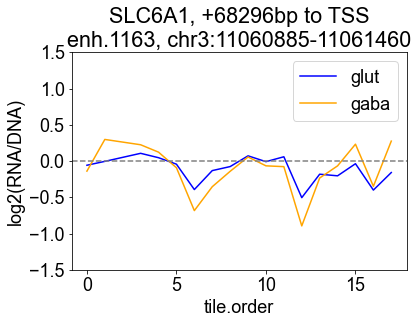

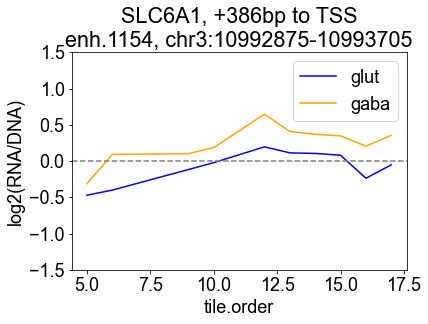

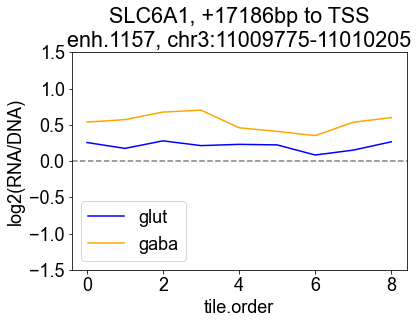

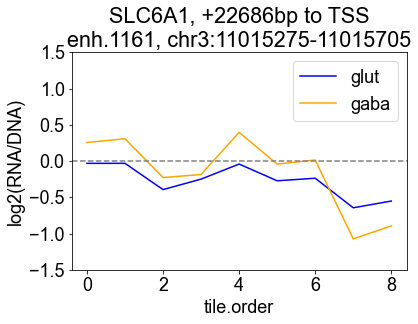

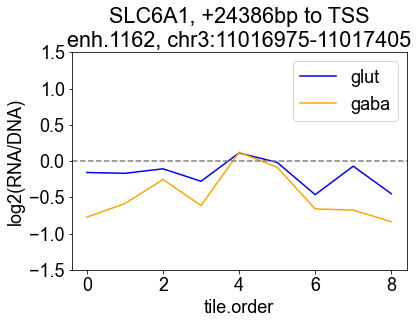

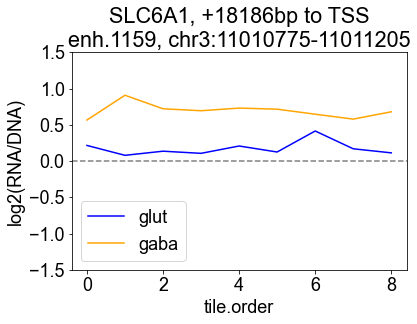

In [40]:
for i in set(test["enh.id"]):
    t = test.loc[test["enh.id"] ==i].copy()
    enh_name = list(set(t["enh.name"]))[0]
    gene_name = list(set(t["gene"]))[0]
    out = os.path.join(PATH, f"{gene_name}.{enh_name}.line.pdf")
    
    
    plot_lineplot(t, out, enh_name)

# BM genes

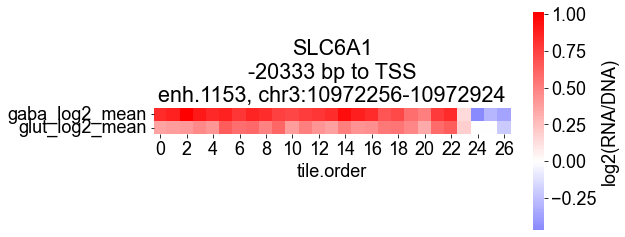

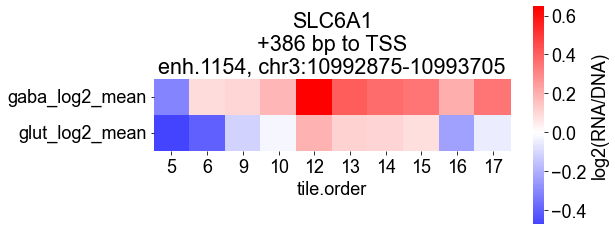

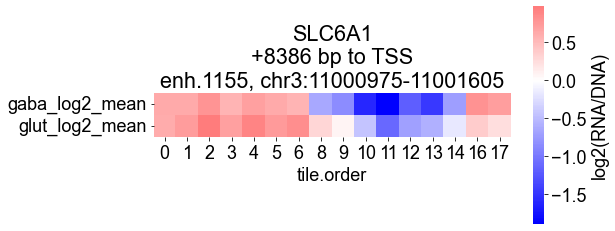

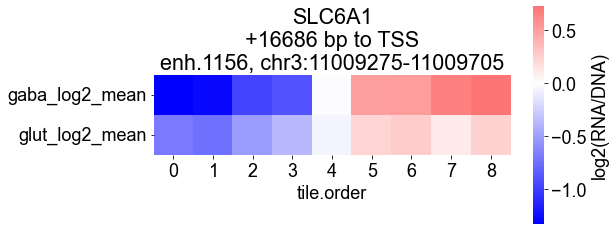

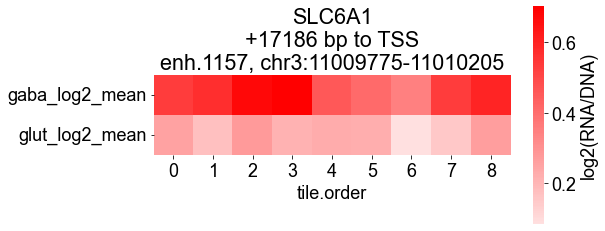

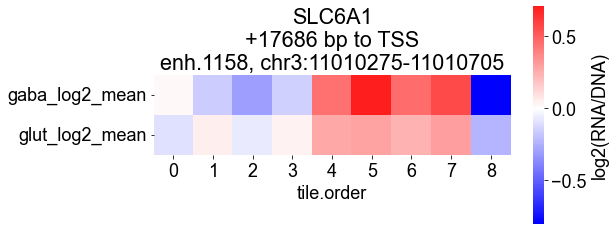

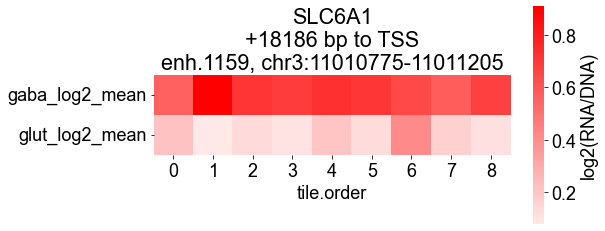

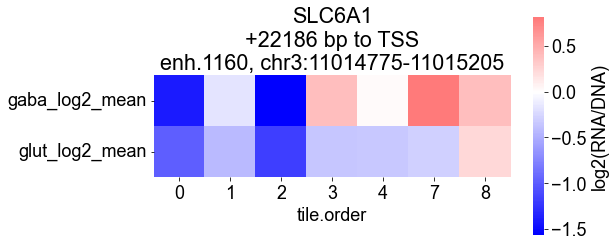

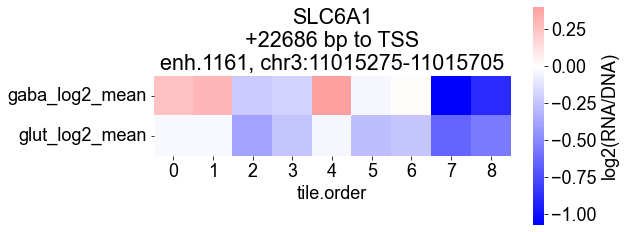

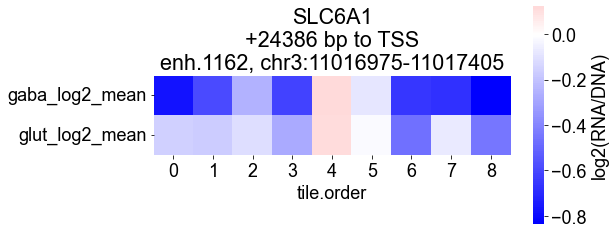

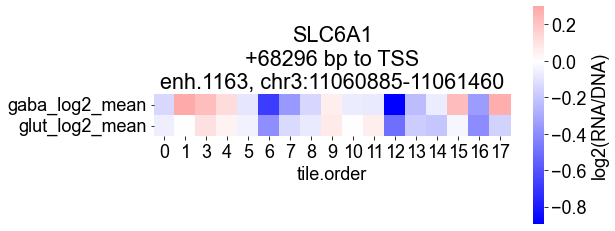

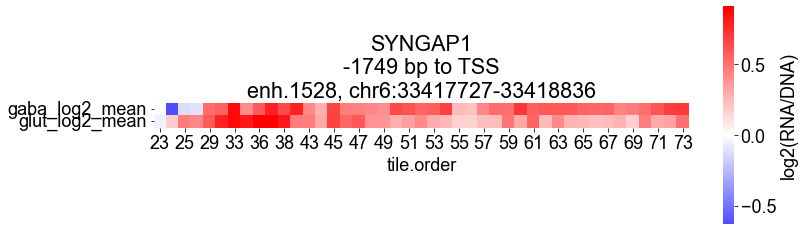

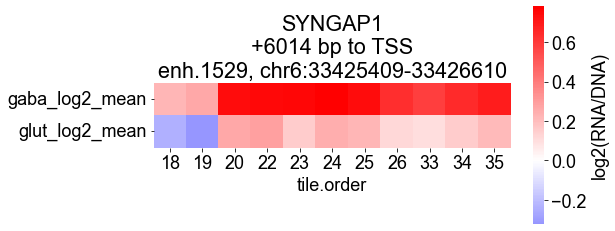

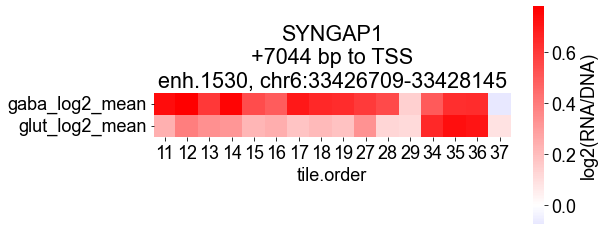

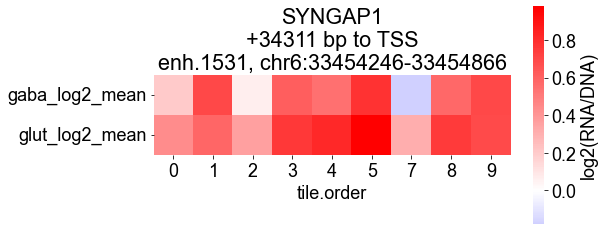

In [47]:
test = test.sort_values(by=["gene", "enh.id"])
for i in test["enh.id"].unique():
    enh_name = list(set(test.loc[test["enh.id"]==i, "enh.name"]))[0]
    gene_name = list(set(test.loc[test["enh.id"]==i, "gene"]))[0]
    out = os.path.join(os.path.split(MPRA)[0], f"{gene_name}.{enh_name}.heatmap.pdf")
    t = test.loc[test["enh.id"] ==i].copy()
    plot_heatmap(t, out, enh_name)

In [50]:
list(test)

['coor',
 'gene',
 'dist',
 'name',
 'sequence',
 'bkgd',
 'h',
 'ctrl',
 'cl',
 'top_bottom',
 'strand',
 '#chr',
 'start.tile',
 'end.tile',
 'gaba_log2_mean',
 'glut_log2_mean',
 'delta',
 'delta_rank',
 '#chr.enh',
 'start.enh',
 'end.enh',
 'enh.id',
 'enh.name',
 'tile.order']

In [78]:
out = os.path.join(os.path.split(MPRA)[0], "BM.within1mb.target.MPRA.tsv")
output = test[[
# 'name',
    'coor',
 'gene',
 'dist',
 'sequence',
 'gaba_log2_mean',
 'glut_log2_mean',
 'delta',
 'delta_rank',
    '#chr',
 'start.tile',
 'end.tile',
 '#chr.enh',
 'start.enh',
 'end.enh',
 'enh.id',
 'enh.name',
 'tile.order']].drop_duplicates()
output["sequence"] =output["sequence"].apply(lambda x: x[15:-15]) # remove adapters
output=output.sort_values(by = "delta", ascending=False)
output.to_csv(out, sep='\t', index=False)

In [61]:
output[['gaba_log2_mean',
 'glut_log2_mean']].corr()

,gaba_log2_mean,glut_log2_mean
gaba_log2_mean,1.000000,0.785058
glut_log2_mean,0.785058,1.000000


In [79]:
output

,coor,gene,dist,sequence,gaba_log2_mean,glut_log2_mean,delta,delta_rank,#chr,start.tile,end.tile,#chr.enh,start.enh,end.enh,enh.id,enh.name,tile.order
41603,chr3:11014915-11015185,SLC6A1,+22326,AGCAGACTGGGCCCCCGCCGGGCAAAGCTGCGGGGAGGAGGCCGCG...,0.811524,-0.289499,1.101023,35361.0,chr3,11014915,11015185,chr3,11014775,11015205,chr3:11014775-11015205,enh.1160,7
41577,chr3:11010795-11011065,SLC6A1,+18206,AGCACAGTCTCATGGAGGGAGTGGGGTGGGGATAGGGGGAGGGGAA...,0.908434,0.079484,0.828950,35213.0,chr3,11010795,11011065,chr3,11010775,11011205,chr3:11010775-11011205,enh.1159,1
41599,chr3:11014835-11015105,SLC6A1,+22246,TGGTTCTCCGTGAACTCTGGGAGGAGATGATGGTGTTTGGTAATGG...,0.387300,-0.345140,0.732441,34989.0,chr3,11014835,11015105,chr3,11014775,11015205,chr3:11014775-11015205,enh.1160,3
41418,chr3:10972296-10972566,SLC6A1,-20293,ACTGCACCTCAGACTCACCTGGAGTGTGCTAGGGAAAGTGCATGAG...,1.011892,0.401605,0.610286,34121.0,chr3,10972296,10972566,chr3,10972256,10972924,chr3:10972256-10972924,enh.1153,2
53541,chr6:33426049-33426319,SYNGAP1,+6114,GGGAGATGGCGCCCTCCTCTGGAAGGTGGAGCGGGACAGGGGCTGT...,0.757376,0.153877,0.603499,34037.0,chr6,33426049,33426319,chr6,33425409,33426610,chr6:33425409-33426610,enh.1529,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53448,chr6:33418206-33418476,SYNGAP1,-1729,GATGAAGGAGGAGCCATGGGAGACTTGACCAATCGACTACCGCATC...,-0.628434,0.180218,-0.808652,1834.0,chr6,33418206,33418476,chr6,33417727,33418836,chr6:33417727-33418836,enh.1528,24
41513,chr3:11001255-11001525,SLC6A1,+8666,GCAGAGCGATGTGTGTTGAATGCTGATTCAGGACCTGCTAGAGTGA...,-1.460991,-0.593325,-0.867666,1461.0,chr3,11001255,11001525,chr3,11000975,11001605,chr3:11000975-11001605,enh.1155,13
41505,chr3:11001175-11001445,SLC6A1,+8586,ATTAAATAGAGTTGGTGGAAGGACTCTGGTTGCCGTGACAACGGAG...,-0.843070,0.076795,-0.919865,1190.0,chr3,11001175,11001445,chr3,11000975,11001605,chr3:11000975-11001605,enh.1155,9
41503,chr3:11001135-11001405,SLC6A1,+8546,CCCTTCCACCAAGCCAGCCCAGCTCCTCCGTTAAGAAATTATTAAA...,-0.641032,0.293156,-0.934188,1117.0,chr3,11001135,11001405,chr3,11000975,11001605,chr3:11000975-11001605,enh.1155,8


In [71]:
output

,coor,gene,dist,sequence,gaba_log2_mean,glut_log2_mean,delta,delta_rank,#chr,start.tile,end.tile,#chr.enh,start.enh,end.enh,enh.id,enh.name,tile.order
41603,chr3:11014915-11015185,SLC6A1,+22326,AGCAGACTGGGCCCCCGCCGGGCAAAGCTGCGGGGAGGAGGCCGCG...,0.811524,-0.289499,1.101023,35361.0,chr3,11014915,11015185,chr3,11014775,11015205,chr3:11014775-11015205,enh.1160,7
41577,chr3:11010795-11011065,SLC6A1,+18206,AGCACAGTCTCATGGAGGGAGTGGGGTGGGGATAGGGGGAGGGGAA...,0.908434,0.079484,0.828950,35213.0,chr3,11010795,11011065,chr3,11010775,11011205,chr3:11010775-11011205,enh.1159,1
41599,chr3:11014835-11015105,SLC6A1,+22246,TGGTTCTCCGTGAACTCTGGGAGGAGATGATGGTGTTTGGTAATGG...,0.387300,-0.345140,0.732441,34989.0,chr3,11014835,11015105,chr3,11014775,11015205,chr3:11014775-11015205,enh.1160,3
41418,chr3:10972296-10972566,SLC6A1,-20293,ACTGCACCTCAGACTCACCTGGAGTGTGCTAGGGAAAGTGCATGAG...,1.011892,0.401605,0.610286,34121.0,chr3,10972296,10972566,chr3,10972256,10972924,chr3:10972256-10972924,enh.1153,2
53541,chr6:33426049-33426319,SYNGAP1,+6114,GGGAGATGGCGCCCTCCTCTGGAAGGTGGAGCGGGACAGGGGCTGT...,0.757376,0.153877,0.603499,34037.0,chr6,33426049,33426319,chr6,33425409,33426610,chr6:33425409-33426610,enh.1529,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53448,chr6:33418206-33418476,SYNGAP1,-1729,GATGAAGGAGGAGCCATGGGAGACTTGACCAATCGACTACCGCATC...,-0.628434,0.180218,-0.808652,1834.0,chr6,33418206,33418476,chr6,33417727,33418836,chr6:33417727-33418836,enh.1528,24
41513,chr3:11001255-11001525,SLC6A1,+8666,GCAGAGCGATGTGTGTTGAATGCTGATTCAGGACCTGCTAGAGTGA...,-1.460991,-0.593325,-0.867666,1461.0,chr3,11001255,11001525,chr3,11000975,11001605,chr3:11000975-11001605,enh.1155,13
41505,chr3:11001175-11001445,SLC6A1,+8586,ATTAAATAGAGTTGGTGGAAGGACTCTGGTTGCCGTGACAACGGAG...,-0.843070,0.076795,-0.919865,1190.0,chr3,11001175,11001445,chr3,11000975,11001605,chr3:11000975-11001605,enh.1155,9
41503,chr3:11001135-11001405,SLC6A1,+8546,CCCTTCCACCAAGCCAGCCCAGCTCCTCCGTTAAGAAATTATTAAA...,-0.641032,0.293156,-0.934188,1117.0,chr3,11001135,11001405,chr3,11000975,11001605,chr3:11000975-11001605,enh.1155,8
